In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

In [3]:
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies',
    storage_options=headers
)[0]['Symbol']


In [3]:
len(tickers)

503

In [8]:
tickers

0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
498     XYL
499     YUM
500    ZBRA
501     ZBH
502     ZTS
Name: Symbol, Length: 503, dtype: object

In [6]:
start= '2020-01-01'

In [10]:
# Remove added tickers and add removed tickers for survivorship bias mitigation
# Get the list of added and removed S&P 500 tickers

try:
    df_changes = pd.read_html(
        'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies',
        storage_options=headers
    )[1]
    
    # Get column names and handle potential variations
    print("Available columns in changes table:", df_changes.columns.tolist())
    
    # Try to find the date column
    date_col = [col for col in df_changes.columns if 'date' in col.lower() or 'added' in col.lower()][0]
    df_changes[date_col] = pd.to_datetime(df_changes[date_col])
    
    # Filter for changes since beginning of 2020
    df_changes_2020 = df_changes[df_changes[date_col] >= '2020-01-01']
    
    print(f"Tickers added since 2020: {len(df_changes_2020)}")
    print(f"Initial ticker count: {len(tickers)}")
    
    # Remove added tickers
    try:
        added_tickers = df_changes_2020['Symbol'].values
        tickers = tickers[~tickers.isin(added_tickers)].reset_index(drop=True)
        print(f"After removing added tickers: {len(tickers)}")
    except:
        print("Could not remove added tickers - proceeding without this step")
    
except Exception as e:
    print(f"Note: Could not process survivorship bias adjustment due to: {str(e)}")
    print("Proceeding with standard S&P 500 list...")

# Final cleanup
tickers = tickers.dropna()
tickers = tickers.drop_duplicates()

print(f"\nFinal ticker count: {len(tickers)}")
print(f"Tickers ready for analysis: {tickers.head(10).tolist()}")

Available columns in changes table: [('Effective Date', 'Effective Date'), ('Added', 'Ticker'), ('Added', 'Security'), ('Removed', 'Ticker'), ('Removed', 'Security'), ('Reason', 'Reason')]
Note: Could not process survivorship bias adjustment due to: 'tuple' object has no attribute 'lower'
Proceeding with standard S&P 500 list...

Final ticker count: 503
Tickers ready for analysis: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [ ]:
# Download adjusted close prices for all tickers
# This may take 3-5 minutes for ~500 stocks

prices = []
symbols = []
failed_tickers = []

print(f"Starting download for {len(tickers)} tickers")
print("This may take several minutes\n")

for i, symbol in enumerate(tickers):
    if (i + 1) % 50 == 0:
        print(f"Progress: {i + 1}/{len(tickers)}")
    
    try:
        # Download without show_errors parameter
        data = yf.download(symbol, start=start, end= '2025-12-1', progress=False)
        
        # Check if we got valid data
        if data is not None and not data.empty:
            # yfinance returns data with MultiIndex columns
            # Extract Close prices
            price_data = None
            
            if isinstance(data.columns, pd.MultiIndex):
                # Access Close column which returns a DataFrame or Series
                try:
                    close_df = data['Close']
                    if isinstance(close_df, pd.Series):
                        price_data = close_df
                    elif isinstance(close_df, pd.DataFrame):
                        if symbol in close_df.columns:
                            price_data = close_df[symbol]
                        else:
                            price_data = close_df.iloc[:, 0]
                except:
                    pass
            
            # Fallback for non-MultiIndex
            if price_data is None:
                if 'Close' in data.columns:
                    price_data = data['Close']
                elif 'Adj Close' in data.columns:
                    price_data = data['Adj Close']
            
            if price_data is not None and not price_data.empty and len(price_data) > 0:
                prices.append(price_data)
                symbols.append(symbol)
            else:
                failed_tickers.append(symbol)
        else:
            failed_tickers.append(symbol)
        
    except Exception as e:
        failed_tickers.append(symbol)
        continue

print(f"\n{'='*60}")
print(f"Download Summary:")
print(f"{'='*60}")
print(f"Successfully downloaded data for {len(symbols)} tickers")
print(f"Failed to download for {len(failed_tickers)} tickers")

if len(prices) > 0:
    print(f"\nDate range: {prices[0].index[0].date()} to {prices[0].index[-1].date()}")
    print(f"Number of trading days: {len(prices[0])}")
    
    # Concatenate all prices into a single DataFrame
    all_prices = pd.concat(prices, axis=1)
    all_prices.columns = symbols[:len(all_prices.columns)]
    
    # Clean up data
    all_prices = all_prices.dropna(axis=1, how='all')  # Drop columns with all NaN
    all_prices = all_prices.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill
    
    print(f"\nPrice data shape: {all_prices.shape}")
    print(f"Columns: {len(all_prices.columns)} stocks")
    print(f"Rows: {len(all_prices)} trading days")
    print(f"Data coverage: {(all_prices.notna().sum().sum() / (all_prices.shape[0] * all_prices.shape[1]) * 100):.2f}%")
    print(f"\nFirst 3 rows of price data:")
    print(all_prices.head(3))
else:
    print("\nERROR: No data was successfully downloaded!")

Starting download for 503 tickers...
This may take several minutes...

Progress: 50/503


Starting download for 503 tickers...
This may take several minutes...

Progress: 50/503


$BRK.B: possibly delisted; no timezone found

1 Failed download:
['BRK.B']: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2020-01-01 -> 2026-01-18)

1 Failed download:
['BF.B']: possibly delisted; no price data found  (1d 2020-01-01 -> 2026-01-18)


Starting download for 503 tickers...
This may take several minutes...

Progress: 50/503


$BRK.B: possibly delisted; no timezone found

1 Failed download:
['BRK.B']: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2020-01-01 -> 2026-01-18)

1 Failed download:
['BF.B']: possibly delisted; no price data found  (1d 2020-01-01 -> 2026-01-18)


Progress: 100/503
Progress: 150/503
Progress: 200/503
Progress: 250/503
Progress: 300/503
Progress: 350/503
Progress: 400/503
Progress: 450/503
Progress: 500/503

Download Summary:
Successfully downloaded data for 501 tickers
Failed to download for 2 tickers

Date range: 2020-01-02 to 2026-01-16
Number of trading days: 1519

Price data shape: (1519, 501)
Columns: 501 stocks
Rows: 1519 trading days
Data coverage: 100.00%

First 3 rows of price data:
                   MMM        AOS        ABT       ABBV         ACN  \
Date                                                                  
2020-01-02  120.682510  42.762718  77.813873  69.266167  192.514969   
2020-01-03  119.643303  42.386734  76.865234  68.608681  192.194427   
2020-01-06  119.757294  42.655300  77.267982  69.150154  190.939331   

                  ADBE        AMD        AES        AFL          A  ...  \
Date                                                                ...   
2020-01-02  334.429993  49.099998  16.107

Starting download for 503 tickers...
This may take several minutes...

Progress: 50/503


$BRK.B: possibly delisted; no timezone found

1 Failed download:
['BRK.B']: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2020-01-01 -> 2026-01-18)

1 Failed download:
['BF.B']: possibly delisted; no price data found  (1d 2020-01-01 -> 2026-01-18)


Progress: 100/503
Progress: 150/503
Progress: 200/503
Progress: 250/503
Progress: 300/503
Progress: 350/503
Progress: 400/503
Progress: 450/503
Progress: 500/503

Download Summary:
Successfully downloaded data for 501 tickers
Failed to download for 2 tickers

Date range: 2020-01-02 to 2026-01-16
Number of trading days: 1519

Price data shape: (1519, 501)
Columns: 501 stocks
Rows: 1519 trading days
Data coverage: 100.00%

First 3 rows of price data:
                   MMM        AOS        ABT       ABBV         ACN  \
Date                                                                  
2020-01-02  120.682510  42.762718  77.813873  69.266167  192.514969   
2020-01-03  119.643303  42.386734  76.865234  68.608681  192.194427   
2020-01-06  119.757294  42.655300  77.267982  69.150154  190.939331   

                  ADBE        AMD        AES        AFL          A  ...  \
Date                                                                ...   
2020-01-02  334.429993  49.099998  16.107

C:\Users\USER\AppData\Local\Temp\ipykernel_36148\1497331890.py:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_prices = all_prices.fillna(method='ffill').fillna(method='bfill')  # Forward and backward fill


In [20]:
# Calculate daily returns
if 'all_prices' in dir() and all_prices is not None and not all_prices.empty:
    daily_returns = all_prices.pct_change()
    
    print("Daily Returns Statistics:")
    print(f"Mean daily return: {daily_returns.mean().mean():.4%}")
    print(f"Std dev of returns: {daily_returns.std().mean():.4%}")
    print("\nFirst 5 rows of daily returns:")
    print(daily_returns.head())
else:
    print("ERROR: all_prices data not available. Please run the previous cell to download data.")

Daily Returns Statistics:
Mean daily return: 0.0698%
Std dev of returns: 2.2426%

First 5 rows of daily returns:
                 MMM       AOS       ABT      ABBV       ACN      ADBE  \
Date                                                                     
2020-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-03 -0.008611 -0.008792 -0.012191 -0.009492 -0.001665 -0.007834   
2020-01-06  0.000953  0.006336  0.005240  0.007892 -0.006530  0.005726   
2020-01-07 -0.004031 -0.006716 -0.005560 -0.005705 -0.021590 -0.000959   
2020-01-08  0.015346 -0.001479  0.004076  0.007087  0.001961  0.013438   

                 AMD       AES       AFL         A  ...       WMB       WTW  \
Date                                                ...                       
2020-01-02       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-01-03 -0.010183 -0.011483 -0.006936 -0.016056  ...  0.004257  0.000245   
2020-01-06 -0.004321  0.011616 -0.002831  0.002956  

In [21]:
# Calculate monthly returns
if 'all_prices' in dir() and all_prices is not None and not all_prices.empty:
    # Method 1: Using percentage change and resampling with compounding
    all_monthly_returns = all_prices.resample('ME').apply(
        lambda x: (x[-1] / x[0] - 1) if len(x) > 1 else np.nan
    )
    
    # Alternative method using compound returns (shown for clarity)
    # all_monthly_returns = all_prices.pct_change().resample('ME').apply(
    #     lambda x: (1 + x).prod() - 1
    # )
    
    print("Monthly Returns shape:", all_monthly_returns.shape)
    print("\nMonthly Returns (first 5 rows):")
    print(all_monthly_returns.head())
    print("\nMonthly Returns Statistics:")
    print(all_monthly_returns.describe())
else:
    print("ERROR: all_prices data not available. Please run the previous cell to download data.")

C:\Users\USER\AppData\Local\Temp\ipykernel_36148\1144298164.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: (x[-1] / x[0] - 1) if len(x) > 1 else np.nan


Monthly Returns shape: (73, 501)

Monthly Returns (first 5 rows):
                 MMM       AOS       ABT      ABBV       ACN      ADBE  \
Date                                                                     
2020-01-31 -0.118556 -0.101476  0.006442 -0.083031 -0.019732  0.049966   
2020-02-29 -0.038307 -0.064570 -0.115208  0.041434 -0.130943 -0.035978   
2020-03-31 -0.107895 -0.077805 -0.033084 -0.140940 -0.138697 -0.116687   
2020-04-30  0.141055  0.196739  0.207755  0.136284  0.202648  0.174065   
2020-05-31  0.063201  0.140456  0.056427  0.118663  0.119552  0.124360   

                 AMD       AES       AFL         A  ...       WMB       WTW  \
Date                                                ...                       
2020-01-31 -0.042770 -0.001460 -0.033364 -0.039441  ... -0.119200  0.034316   
2020-02-29 -0.052895 -0.176268 -0.171728 -0.061838  ... -0.098012 -0.120218   
2020-03-31 -0.041719 -0.253568 -0.243983 -0.124042  ... -0.259574 -0.145316   
2020-04-30  0.199954

In [22]:
# Momentum Trading Strategy Function
def momentum_strategy(monthly_returns, lookback=12, top_n=50, strategy_type='long'):
    """
    Calculate momentum trading strategy returns.
    
    Parameters:
    -----------
    monthly_returns : DataFrame
        Monthly returns data
    lookback : int
        Number of months to look back for momentum calculation
    top_n : int
        Number of top performers to include in portfolio
    strategy_type : str
        'long' for long positions, 'short' for short positions, 'both' for long-short
    
    Returns:
    --------
    Series
        Cumulative returns of the momentum strategy
    """
    
    # Calculate rolling n-month returns
    momentum_lookback = monthly_returns.rolling(window=lookback).apply(
        lambda x: (1 + x).prod() - 1, raw=False
    )
    
    # Remove NaN values
    momentum_lookback = momentum_lookback.dropna()
    
    # Store portfolio returns
    portfolio_returns = []
    
    # Iterate through each month
    for i in range(len(momentum_lookback) - 1):
        # Current momentum scores
        current_momentum = momentum_lookback.iloc[i]
        
        if strategy_type in ['long', 'both']:
            # Find top performers
            winners = current_momentum.nlargest(top_n).index
            
            # Get returns for next month
            next_month_returns = monthly_returns.iloc[i + 1]
            winner_returns = next_month_returns[winners]
            
            # Mean return of winners
            if len(winner_returns) > 0:
                mean_return = winner_returns.mean()
            else:
                mean_return = 0
        else:
            mean_return = 0
        
        if strategy_type in ['short', 'both']:
            # Find bottom performers
            losers = current_momentum.nsmallest(top_n).index
            
            # Get returns for next month
            next_month_returns = monthly_returns.iloc[i + 1]
            loser_returns = next_month_returns[losers]
            
            # Mean return of losers (short)
            if len(loser_returns) > 0:
                short_return = -loser_returns.mean()
            else:
                short_return = 0
        else:
            short_return = 0
        
        # Combine returns
        if strategy_type == 'long':
            portfolio_return = mean_return
        elif strategy_type == 'short':
            portfolio_return = short_return
        else:  # both
            portfolio_return = (mean_return + short_return) / 2
        
        portfolio_returns.append(portfolio_return)
    
    # Convert to cumulative returns
    portfolio_returns = pd.Series(portfolio_returns, index=momentum_lookback.index[:-1])
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    
    return cumulative_returns

# Test the strategy with 12-month lookback and top 50 stocks
print("Testing Momentum Strategy...")
momentum_returns_12m = momentum_strategy(all_monthly_returns, lookback=12, top_n=50, strategy_type='long')

print(f"\n12-Month Lookback (Top 50 Long):")
print(f"Total Return: {momentum_returns_12m.iloc[-1]:.2%}")
print(f"Annualized Return: {(1 + momentum_returns_12m.iloc[-1])**(1/(len(momentum_returns_12m)/12)) - 1:.2%}")
print(f"Max Drawdown: {(momentum_returns_12m.cummax() - momentum_returns_12m).max():.2%}")
print(f"Volatility: {momentum_returns_12m.diff().std():.2%}")


Testing Momentum Strategy...

12-Month Lookback (Top 50 Long):
Total Return: 2772.16%
Annualized Return: 93.58%
Max Drawdown: 83.95%
Volatility: 79.80%


In [23]:
# Test different lookback periods and portfolio sizes
print("Testing Different Lookback Periods:\n")
print(f"{'Lookback':<12} {'Top 50 Return':<16} {'Top 100 Return':<18} {'Top 10% Return':<18}")
print("-" * 65)

results = {}
for lookback in range(1, 13):
    ret_50 = momentum_strategy(all_monthly_returns, lookback=lookback, top_n=50)
    ret_100 = momentum_strategy(all_monthly_returns, lookback=lookback, top_n=100)
    
    # Calculate top 10% (approximately 50 stocks out of ~500)
    top_pct = max(50, int(len(symbols) * 0.10))
    ret_pct = momentum_strategy(all_monthly_returns, lookback=lookback, top_n=top_pct)
    
    results[lookback] = {
        'top_50': ret_50.iloc[-1],
        'top_100': ret_100.iloc[-1],
        'top_10pct': ret_pct.iloc[-1]
    }
    
    print(f"{lookback} months    {ret_50.iloc[-1]:<15.2%}  {ret_100.iloc[-1]:<17.2%}  {ret_pct.iloc[-1]:<17.2%}")

print("\nBest performing lookback period (Top 50): ", 
      max(results.items(), key=lambda x: x[1]['top_50'])[0], "months")

Testing Different Lookback Periods:

Lookback     Top 50 Return    Top 100 Return     Top 10% Return    
-----------------------------------------------------------------
1 months    219.16%          196.37%            219.16%          
2 months    193234.15%       38771.72%          193234.15%       
3 months    63091.23%        14759.94%          63091.23%        
4 months    28225.75%        8396.30%           28225.75%        
5 months    15699.57%        5546.81%           15699.57%        
6 months    12567.53%        4110.81%           12567.53%        
7 months    7404.17%         2840.43%           7404.17%         
8 months    5871.85%         2357.28%           5871.85%         
9 months    4372.24%         1920.83%           4372.24%         
10 months    3417.25%         1557.08%           3417.25%         
11 months    2748.68%         1345.00%           2748.68%         
12 months    2772.16%         1314.89%           2772.16%         

Best performing lookback period (

In [26]:
# Download S&P 500 benchmark for comparison
sp500 = yf.download('^GSPC', start=start, progress=False)

# Handle MultiIndex columns from yfinance
if isinstance(sp500.columns, pd.MultiIndex):
    sp500_close = sp500['Close'].iloc[:, 0] if isinstance(sp500['Close'], pd.DataFrame) else sp500['Close']
else:
    sp500_close = sp500['Close']

# Calculate monthly returns
sp500_monthly = sp500_close.resample('ME').apply(lambda x: x.iloc[-1] / x.iloc[0] - 1 if len(x) > 0 else np.nan)
sp500_cumulative = (1 + sp500_monthly).cumprod() - 1

# Convert to float to ensure proper formatting
sp500_total_return = float(sp500_cumulative.iloc[-1])
sp500_volatility = float(sp500_monthly.std())

print("S&P 500 Benchmark Performance:")
print(f"Total Return: {sp500_total_return:.2%}")
print(f"Volatility: {sp500_volatility:.2%}")

# Compare momentum strategies with benchmark
print("\n" + "="*70)
print("MOMENTUM STRATEGY VS. S&P 500 BENCHMARK")
print("="*70)

comparison_lookbacks = [1, 3, 6, 12]
for lb in comparison_lookbacks:
    mom_ret = momentum_strategy(all_monthly_returns, lookback=lb, top_n=50)
    alpha = float(mom_ret.iloc[-1]) - sp500_total_return
    
    print(f"\n{lb}-Month Lookback (Top 50):")
    print(f"  Momentum Return:        {float(mom_ret.iloc[-1]):>8.2%}")
    print(f"  S&P 500 Return:         {sp500_total_return:>8.2%}")
    print(f"  Outperformance:         {alpha:>8.2%}")
    print(f"  Momentum Volatility:    {float(mom_ret.diff().std()):>8.2%}")
    print(f"  S&P 500 Volatility:     {sp500_volatility:>8.2%}")

S&P 500 Benchmark Performance:
Total Return: 97.58%
Volatility: 5.18%

MOMENTUM STRATEGY VS. S&P 500 BENCHMARK

1-Month Lookback (Top 50):
  Momentum Return:         219.16%
  S&P 500 Return:           97.58%
  Outperformance:          121.58%
  Momentum Volatility:       9.22%
  S&P 500 Volatility:        5.18%

3-Month Lookback (Top 50):
  Momentum Return:        63091.23%
  S&P 500 Return:           97.58%
  Outperformance:         62993.65%
  Momentum Volatility:    1664.19%
  S&P 500 Volatility:        5.18%

6-Month Lookback (Top 50):
  Momentum Return:        12567.53%
  S&P 500 Return:           97.58%
  Outperformance:         12469.95%
  Momentum Volatility:     320.09%
  S&P 500 Volatility:        5.18%

12-Month Lookback (Top 50):
  Momentum Return:        2772.16%
  S&P 500 Return:           97.58%
  Outperformance:         2674.58%
  Momentum Volatility:      79.80%
  S&P 500 Volatility:        5.18%


In [30]:
# Comprehensive Performance Analytics
def calculate_metrics(returns_series, benchmark_series, risk_free_rate=0.02):
    """Calculate comprehensive performance metrics"""
    
    # Convert annual risk-free rate to monthly
    rf_monthly = risk_free_rate / 12
    
    # Basic metrics
    total_return = returns_series.iloc[-1]
    num_months = len(returns_series)
    annualized_return = (1 + total_return) ** (12 / num_months) - 1
    
    # Monthly returns for volatility calculation
    monthly_rets = returns_series.diff().dropna()
    volatility = monthly_rets.std() * np.sqrt(12)
    
    # Sharpe Ratio
    excess_returns = monthly_rets - rf_monthly
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(12) if excess_returns.std() > 0 else 0
    
    # Maximum Drawdown
    cumulative = (1 + returns_series)
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Win Rate
    win_rate = (monthly_rets > 0).sum() / len(monthly_rets) if len(monthly_rets) > 0 else 0
    
    # Benchmark comparison
    monthly_bench = benchmark_series.diff().dropna()
    correlation = monthly_rets.corr(monthly_bench)
    
    # Excess return
    excess_return = total_return - benchmark_series.iloc[-1]
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Correlation with S&P 500': correlation,
        'Excess Return vs S&P 500': excess_return,
        'Number of Months': num_months
    }

# Calculate metrics for different strategies
print("="*80)
print("COMPREHENSIVE PERFORMANCE ANALYSIS")
print("="*80)

strategies = [
    ('12-Month Lookback, Top 50', 12, 50),
    ('6-Month Lookback, Top 50', 6, 50),
    ('3-Month Lookback, Top 50', 3, 50),
    ('12-Month Lookback, Top 100', 12, 100),
]

metrics_results = {}
for strategy_name, lookback, top_n in strategies:
    mom_returns = momentum_strategy(all_monthly_returns, lookback=lookback, top_n=top_n)
    metrics = calculate_metrics(mom_returns, sp500_cumulative)
    metrics_results[strategy_name] = metrics
    
    print(f"\n{strategy_name}")
    print("-" * 80)
    print(f"Total Return:              {metrics['Total Return']:>10.2%}")
    print(f"Annualized Return:         {metrics['Annualized Return']:>10.2%}")
    print(f"Volatility (Annual):       {metrics['Volatility']:>10.2%}")
    print(f"Sharpe Ratio:              {metrics['Sharpe Ratio']:>10.2f}")
    print(f"Max Drawdown:              {metrics['Max Drawdown']:>10.2%}")
    print(f"Win Rate:                  {metrics['Win Rate']:>10.2%}")
    print(f"Correlation with S&P 500:  {metrics['Correlation with S&P 500']:>10.2f}")
    print(f"Excess Return vs S&P 500:  {metrics['Excess Return vs S&P 500']:>10.2%}")

# S&P 500 baseline
print(f"\n{'S&P 500 Benchmark'}")
print("-" * 80)
sp500_metrics = calculate_metrics(sp500_cumulative, sp500_cumulative)
print(f"Total Return:              {sp500_metrics['Total Return']:>10.2%}")
print(f"Annualized Return:         {sp500_metrics['Annualized Return']:>10.2%}")
print(f"Volatility (Annual):       {sp500_metrics['Volatility']:>10.2%}")
print(f"Sharpe Ratio:              {sp500_metrics['Sharpe Ratio']:>10.2f}")
print(f"Max Drawdown:              {sp500_metrics['Max Drawdown']:>10.2%}")
print(f"Win Rate:                  {sp500_metrics['Win Rate']:>10.2%}")

COMPREHENSIVE PERFORMANCE ANALYSIS

12-Month Lookback, Top 50
--------------------------------------------------------------------------------
Total Return:                2772.16%
Annualized Return:             93.58%
Volatility (Annual):          276.45%
Sharpe Ratio:                    2.00
Max Drawdown:                 -14.36%
Win Rate:                      78.33%
Correlation with S&P 500:        0.16
Excess Return vs S&P 500:    2674.58%

6-Month Lookback, Top 50
--------------------------------------------------------------------------------
Total Return:               12567.53%
Annualized Return:            138.01%
Volatility (Annual):         1108.84%
Sharpe Ratio:                    2.06
Max Drawdown:                  -9.16%
Win Rate:                      83.33%
Correlation with S&P 500:        0.07
Excess Return vs S&P 500:   12469.95%

3-Month Lookback, Top 50
--------------------------------------------------------------------------------
Total Return:               63091.2


LONG vs. SHORT vs. LONG-SHORT ANALYSIS (12-Month Lookback, Top 50)

Long (Winners)
Total Return:                2772.16%
Annualized Return:             93.58%
Volatility:                   276.45%
Sharpe Ratio:                    2.00
Max Drawdown:                 -14.36%

Short (Losers)
Total Return:                 332.55%
Annualized Return:             33.39%
Volatility:                    45.03%
Sharpe Ratio:                    1.37
Max Drawdown:                 -20.70%

Long-Short
Total Return:                1179.64%
Annualized Return:             65.12%
Volatility:                    64.43%
Sharpe Ratio:                    3.62
Max Drawdown:                  -0.44%


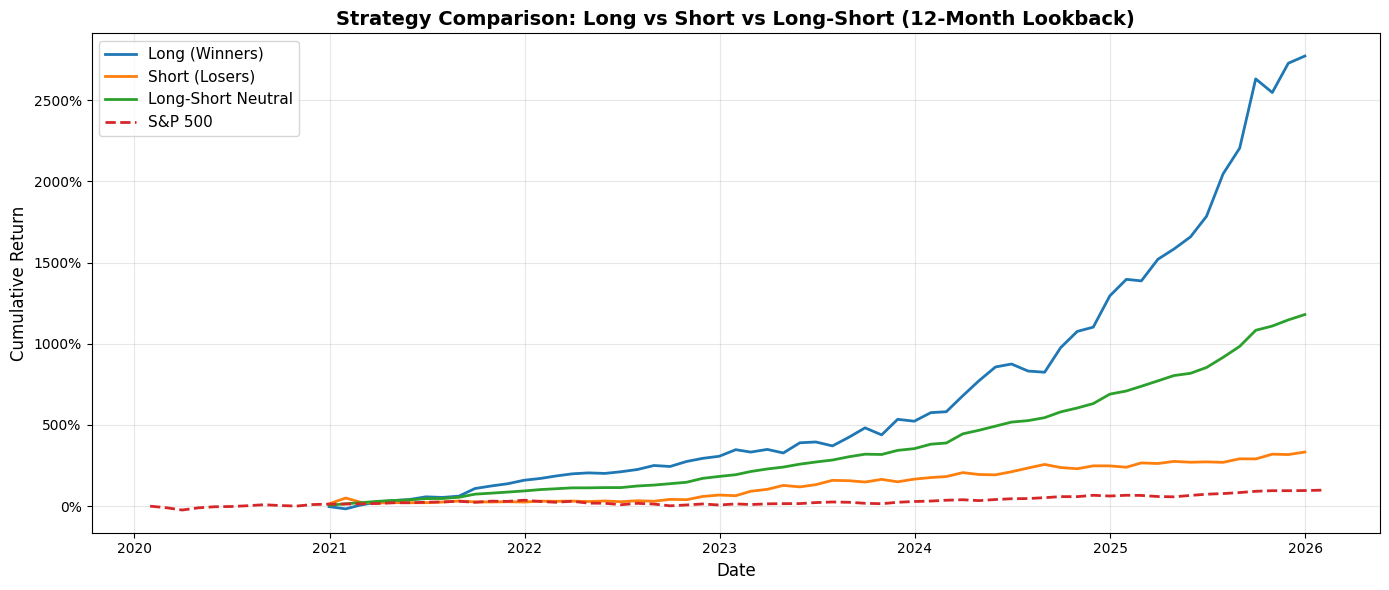

In [31]:
# Long vs. Short vs. Long-Short Strategies
print("\n" + "="*80)
print("LONG vs. SHORT vs. LONG-SHORT ANALYSIS (12-Month Lookback, Top 50)")
print("="*80)

mom_long = momentum_strategy(all_monthly_returns, lookback=12, top_n=50, strategy_type='long')
mom_short = momentum_strategy(all_monthly_returns, lookback=12, top_n=50, strategy_type='short')
mom_both = momentum_strategy(all_monthly_returns, lookback=12, top_n=50, strategy_type='both')

strategies_comparison = {
    'Long (Winners)': mom_long,
    'Short (Losers)': mom_short,
    'Long-Short': mom_both
}

for strategy_name, returns in strategies_comparison.items():
    metrics = calculate_metrics(returns, sp500_cumulative)
    print(f"\n{strategy_name}")
    print(f"Total Return:              {metrics['Total Return']:>10.2%}")
    print(f"Annualized Return:         {metrics['Annualized Return']:>10.2%}")
    print(f"Volatility:                {metrics['Volatility']:>10.2%}")
    print(f"Sharpe Ratio:              {metrics['Sharpe Ratio']:>10.2f}")
    print(f"Max Drawdown:              {metrics['Max Drawdown']:>10.2%}")

# Visualize comparison
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(mom_long.index, mom_long.values, label='Long (Winners)', linewidth=2)
ax.plot(mom_short.index, mom_short.values, label='Short (Losers)', linewidth=2)
ax.plot(mom_both.index, mom_both.values, label='Long-Short Neutral', linewidth=2)
ax.plot(sp500_cumulative.index, sp500_cumulative.values, label='S&P 500', linewidth=2, linestyle='--')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.set_title('Strategy Comparison: Long vs Short vs Long-Short (12-Month Lookback)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

In [32]:
# Analyze top momentum stocks (most recent snapshot)
print("\n" + "="*80)
print("TOP MOMENTUM STOCKS - CURRENT SNAPSHOT")
print("="*80)

# Calculate 12-month momentum for current period
momentum_12m = all_monthly_returns.rolling(window=12).apply(lambda x: (1 + x).prod() - 1)
latest_momentum = momentum_12m.iloc[-1].sort_values(ascending=False)

print(f"\nTop 20 Performers (12-Month Momentum):")
print(f"{'Rank':<6} {'Ticker':<8} {'Return':<12}")
print("-" * 30)
for i, (ticker, value) in enumerate(latest_momentum.head(20).items(), 1):
    print(f"{i:<6} {ticker:<8} {value:>10.2%}")

print(f"\nBottom 20 Performers (12-Month Momentum):")
print(f"{'Rank':<6} {'Ticker':<8} {'Return':<12}")
print("-" * 30)
for i, (ticker, value) in enumerate(latest_momentum.tail(20).items(), 1):
    print(f"{i:<6} {ticker:<8} {value:>10.2%}")

# Sector/Stock concentration analysis
top_50_winners = latest_momentum.head(50).index.tolist()
print(f"\n12-Month Momentum Distribution (Top 50 Winners):")
print(f"Mean 12-month return: {latest_momentum[top_50_winners].mean():.2%}")
print(f"Median 12-month return: {latest_momentum[top_50_winners].median():.2%}")
print(f"Std Dev: {latest_momentum[top_50_winners].std():.2%}")
print(f"Min: {latest_momentum[top_50_winners].min():.2%}")
print(f"Max: {latest_momentum[top_50_winners].max():.2%}")


TOP MOMENTUM STOCKS - CURRENT SNAPSHOT

Top 20 Performers (12-Month Momentum):
Rank   Ticker   Return      
------------------------------
1      SNDK        826.41%
2      WDC         275.03%
3      WBD         249.73%
4      MU          224.14%
5      STX         213.81%
6      HOOD        156.95%
7      FIX         148.99%
8      LRCX        142.03%
9      NEM         141.38%
10     HII         138.17%
11     ALB         135.86%
12     INTC        135.50%
13     PLTR        128.77%
14     APH         122.24%
15     DG          115.88%
16     KLAC        110.21%
17     GEV         108.09%
18     AMD          98.60%
19     DLTR         93.91%
20     TER          92.68%

Bottom 20 Performers (12-Month Momentum):
Rank   Ticker   Return      
------------------------------
1      ARE         -29.96%
2      HPQ         -30.73%
3      ZBRA        -31.06%
4      NOW         -31.63%
5      CPB         -31.97%
6      PYPL        -32.83%
7      FDS         -33.17%
8      CAG         -33.85%
9